## Objectives
Bag of visual Words(BOW),

## Import libraries, download images

In [1]:
from IPython.display import clear_output
# clear_output()

In [2]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import math

## Download images

In [3]:
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/bc8bffbc40fa5a1dd9c4bca6b447f01e574c4c57/book_scene.jpg?raw=true -O book_scene.jpg
clear_output()

## Helper functions

In [4]:
# funcrion to read and resize an image
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result


def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])

    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def show_in_column(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(count, 1, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])

    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

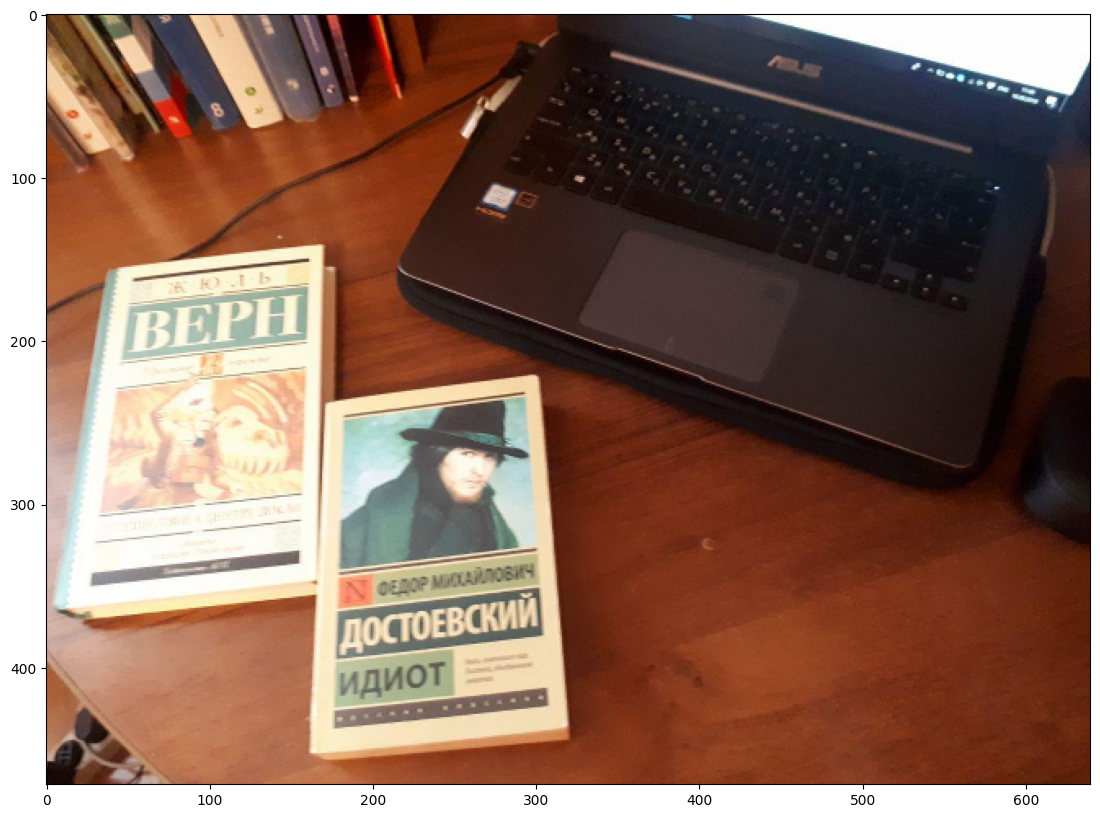

In [5]:
book_scene = read_and_resize("book_scene.jpg")
plt.imshow(book_scene)
plt.show()

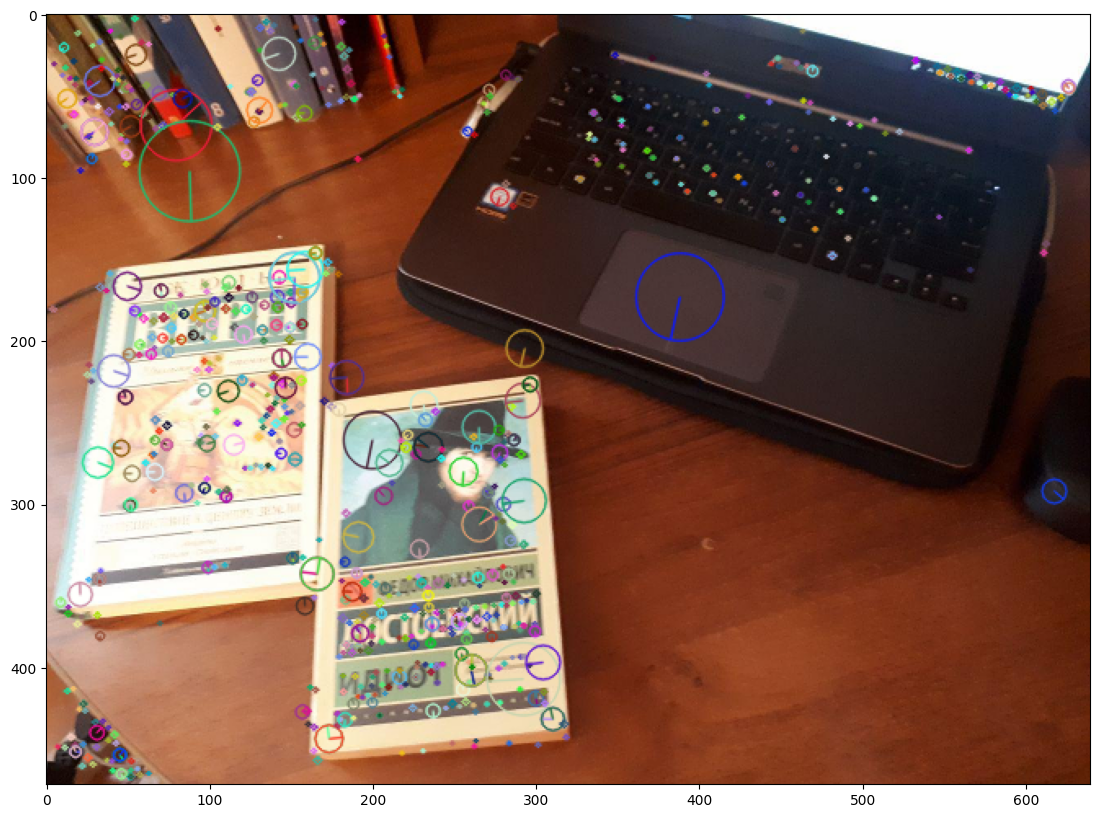

Pos: (3.840630292892456, 180.36634826660156) 
Size: 3.106260061264038 
Angle: 64.4161605834961
Desc: (128,)


In [6]:
def processSIFT(img):
  sift = cv2.SIFT_create()
  return sift.detectAndCompute(book_scene, None)

kp, descriptors = processSIFT(book_scene)
book_scene_desc = cv2.drawKeypoints(book_scene, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_in_row([book_scene_desc])
print("Pos:",kp[0].pt, "\nSize:", kp[0].size, "\nAngle:", kp[0].angle)
print("Desc:", descriptors[0].shape)

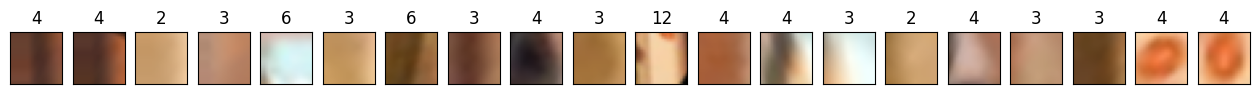

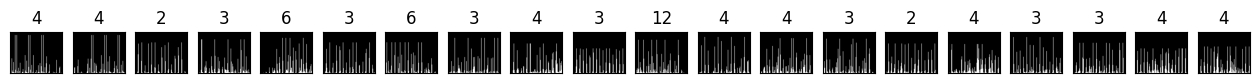

In [7]:
def crop_rect(img, rect, dst_size=(20, 20)):
  center, size, angle = rect[0], rect[1], rect[2]
  center, size = tuple(map(int, center)), tuple(map(int, size))
  height, width = img.shape[0], img.shape[1]
  M = cv2.getRotationMatrix2D(center, angle, dst_size[0] / size[0])

  # Applies an affine transformation to an image.
  # The function warpAffine transforms the source image using the specified matrix

  img_rot = cv2.warpAffine(img, M, (width, height))
  # show_in_row(img_rot)
  # Retrieves a pixel rectangle from an image with sub-pixel accuracy

  img_crop = cv2.getRectSubPix(img_rot, dst_size, center)
  return img_crop


def visualize_hist(vec, height = 100, bin_width = 3, divider = None):
  img = np.zeros((height, bin_width * len(vec)), dtype='uint8')
  if divider is None: divider = np.max(vec)
#   print(divider)`
  for idx, val in enumerate(vec):
    val = math.ceil(val * height / divider)
    if val > 0: img[-val:, idx*bin_width:(idx+1)*bin_width] = 255
  return img


def get_kp_img(img, k):
  return crop_rect(img, (k.pt, (2*k.size, 2*k.size), k.angle))


def show_key_point_and_hist(img, key_points, descs):
  img_list = []
  hist_list = []
  info_list = []
  for idx, k in enumerate(key_points):
    cimg = get_kp_img(img, k)
    img_list.append(cimg)
    hist_img = visualize_hist(descs[idx], height = 300, divider = 200)
    hist_list.append(hist_img)
    info_list.append(str(math.ceil(k.size)))
  show_in_row(img_list, info_list, True)
  show_in_row(hist_list, info_list, True)

from_idx = 0
to_idx = from_idx+20
show_key_point_and_hist(book_scene, kp[from_idx:to_idx], descriptors[from_idx:to_idx])

# plt.plot(descriptors[0])
# plt.show()

## Implement vector distance metric

From slides:
![alt tex t](https://drive.google.com/uc?export=view&id=1sggfpcQvkbkYnIrQ50EcMvRso4VLekL6)

In [8]:
def euclid_dist(v1, v2):
  diff = v1 - v2
  return np.sum(diff ** 2) ** 0.5

def cosine_dist(v1, v2):
  # TODO
  v1norm = np.linalg.norm(v1)
  v2norm = np.linalg.norm(v2)
  cos_dist = np.dot(v1, v2) / (v1norm * v2norm)
  return 1 - cos_dist

for i in range(1, 5):
  d1 = euclid_dist(descriptors[i-1], descriptors[i])
  d2 = cosine_dist(descriptors[i-1], descriptors[i])
  print("Euclid1: ", d1, "Cosine2: ", d2)

Euclid1:  367.3526915649319 Cosine2:  0.25763368606567383
Euclid1:  560.5613258154722 Cosine2:  0.5997228622436523
Euclid1:  469.0287837649199 Cosine2:  0.4190799593925476
Euclid1:  556.0791310596002 Cosine2:  0.5889237225055695


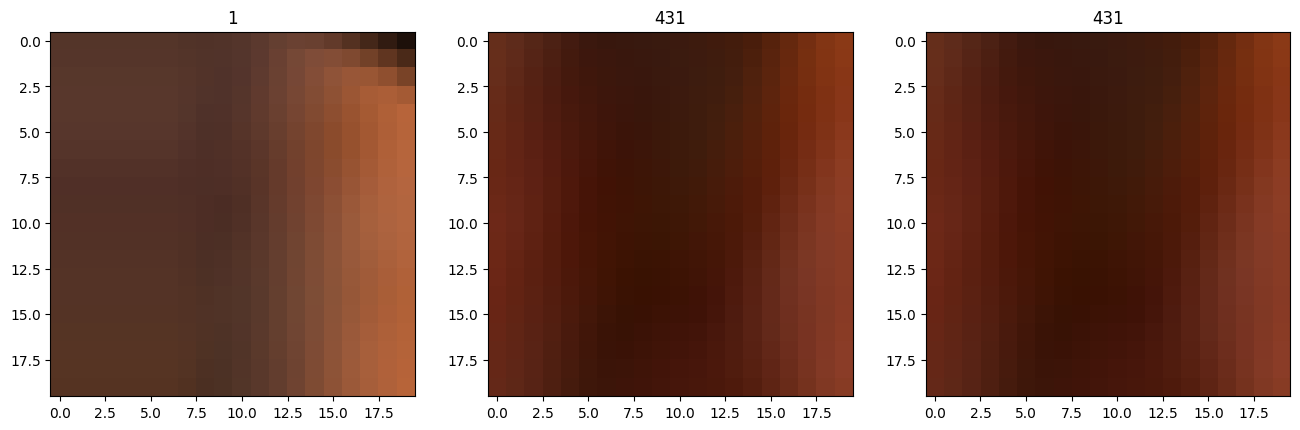

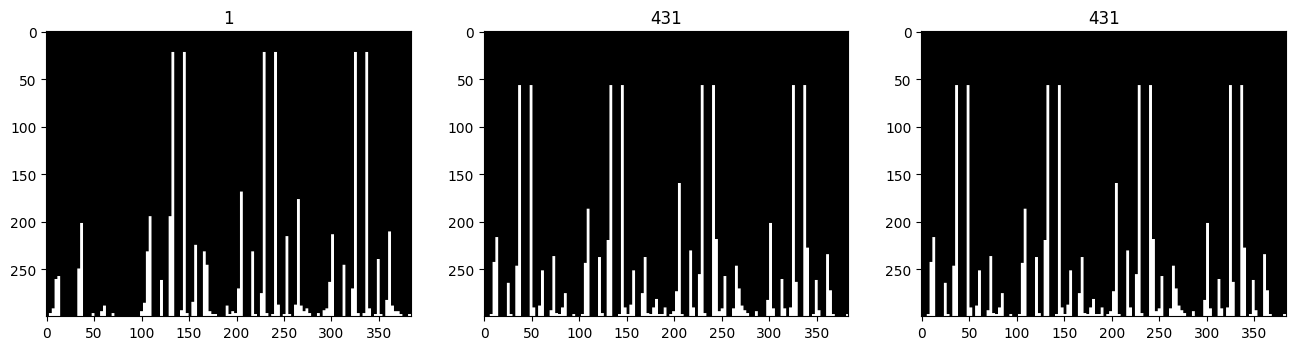

In [9]:
def find_closest_idx(desc, idx, metric):
  # TODO
  min_idx = 0
  min_dist = 999999.0
  for i in range(len(desc)):
    if i == idx: continue
    dist = metric(desc[idx], desc[i])
    if dist < min_dist:
      min_idx = i
      min_dist = dist

  return min_idx

def show_keypoints(kp, descs, indexes):
  show_in_row([get_kp_img(book_scene, kp[i]) for i in indexes], [str(i) for i in indexes])
  show_in_row([visualize_hist(descriptors[i], height = 300, divider = 200) for i in indexes], [str(i) for i in indexes])

def show_closest_keypoints(kp, descs, idx):
  idx_euclid = find_closest_idx(descriptors, idx, euclid_dist)
  idx_cos = find_closest_idx(descriptors, idx, cosine_dist)

  indexes = [idx, idx_euclid, idx_cos]
  show_keypoints(kp, descs, indexes)


show_closest_keypoints(kp, descriptors, 1)

# KMean clustering

1) Initalize centroids at random points<br>
2) Assign points to closest centroid<br>
3) Move centroids to avg value of its points<br>
4) Repeat steps 2-3 N times<br>
5) Profit<br>

In [ ]:
from tqdm import tqdm
import random

# TODO
def find_closest_idx(descriptors, desc, metric):
  # TODO
  min_idx = 0
  min_dist = 99999999.0
  for i in range(len(descriptors)):
    dist = metric(descriptors[i], desc)
    if dist < min_dist:
      min_idx = i
      min_dist = dist

  return min_idx

def kmeans(descriptors, clusters_count, metric, iterations = 50 ):


  # step 1
  clusters = random.choices(descriptors, k=clusters_count)
  clusters_indices = [[] for _ in range(clusters_count)]

  for iter_idx in tqdm(range(iterations), desc="iteration"):
    # step 2
    clusters_indices = [[] for _ in range(clusters_count)]

    for i in range(len(descriptors)):

      close_idx = find_closest_idx(clusters, descriptors[i], metric)
      clusters_indices[close_idx].append(i)

    #step 3
    for i in range(clusters_count):
      mean_val = np.zeros(descriptors[0].shape)
      for idx in clusters_indices[i]:
        mean_val += descriptors[idx]
      clusters[i] = mean_val / float(len(clusters_indices[i]))

  return clusters_indices

clusters = kmeans(descriptors, 60, cosine_dist, 30)

iteration:   0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-48-764b796a66fb>:45: RuntimeWarning: invalid value encountered in divide
  clusters[i] = mean_val / float(len(clusters_indices[i]))
iteration: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


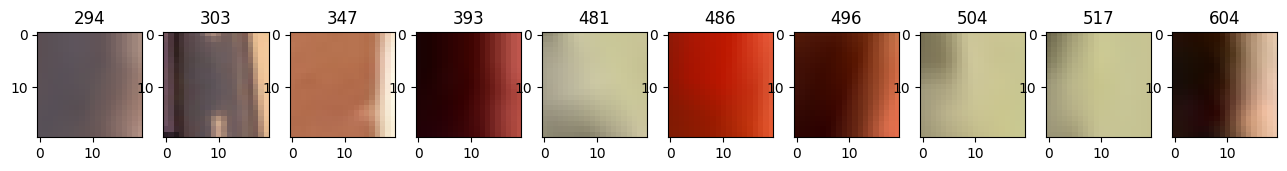

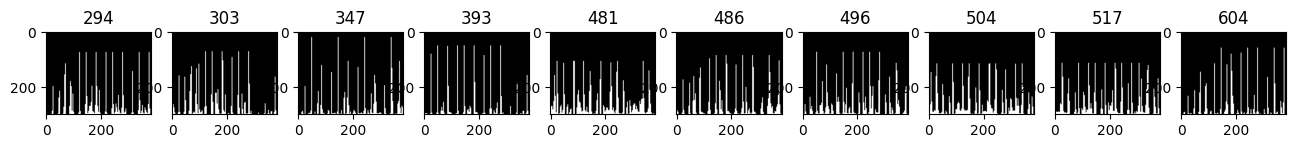

In [ ]:
show_keypoints(kp, descriptors, clusters[1][:10])